In [1]:
import pickle
import os
import functools
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.7"

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import scipy.stats

from itertools import product

import pandas as pd

import nuSQuIDS as nsq
from scipy.interpolate import RectBivariateSpline, UnivariateSpline
import h5py
import pickle


## Transmission Probability

In [4]:
units = nsq.Const()
interactions = True

E_min = 1.0e2*units.GeV
E_max = 1.0e8*units.GeV
E_nodes = 200
energy_nodes = nsq.logspace(E_min,E_max,E_nodes)

neutrino_flavors = 3

nuSQ = nsq.nuSQUIDS(energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)


N0 = 1.0e18; Power = -1.0
Eflux = lambda E: N0*E**Power

InitialFlux = np.zeros((E_nodes,2,3))
InitialFlux[:] = Eflux(nuSQ.GetERange()).reshape((E_nodes, 1, 1))


nuSQ.Set_rel_error(1.0e-7)
nuSQ.Set_abs_error(1.0e-7)
#nuSQ.Set_h_max(500.0*units.km)
nuSQ.Set_MixingParametersToDefault()

n_thetas = 50
flux_ratio_theta =  np.zeros((E_nodes, n_thetas, 2 ,3))
cthetas = np.linspace(-1, 1, n_thetas)
n_energies = len(nuSQ.GetERange())
for j, ctheta in enumerate(cthetas):
    earth = nsq.EarthAtm()
    nuSQ.Set_Body(earth)
    nuSQ.Set_Track(nsq.EarthAtm.Track(earth.MakeTrackWithCosine(ctheta)))
    nuSQ.Set_initial_state(InitialFlux,nsq.Basis.flavor)
    nuSQ.Set_TauRegeneration(True)

    nuSQ.EvolveState()


    for nutype, nuflavor, i_energy in product(range(2), range(3), range(n_energies)):
        flux_ratio_theta[i_energy, j, nutype, nuflavor] = (
            nuSQ.EvalFlavorAtNode(nuflavor, i_energy, nutype) /
            InitialFlux[i_energy][nutype][nuflavor]
        )

log10_energies = np.log10(nuSQ.GetERange()/units.GeV)


nutypes = ["", "bar"]
nuflavors = ["nue", "numu", "nutau"]

transm_splines = {}

for nutype, nuflavor in product(range(2), range(3)):
    transmission_prob_spline = RectBivariateSpline(cthetas, log10_energies, flux_ratio_theta[:, :, 0, 0].T)

    name = nuflavors[nuflavor] + nutypes[nutype]

    transm_splines[name] = transmission_prob_spline




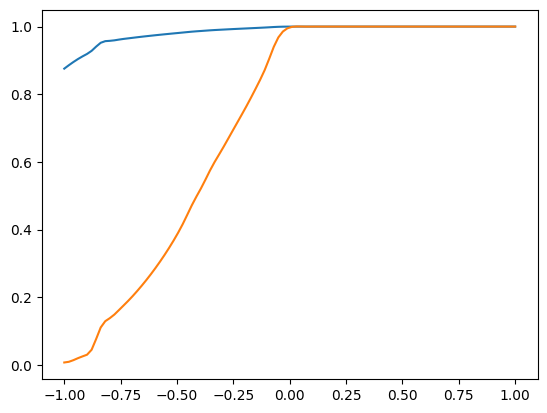

In [4]:
cs = np.linspace(-1, 1, 100)
plt.plot(cs, transmission_prob_spline(cs, np.log10(1E4), grid=False))
plt.plot(cs, transmission_prob_spline(cs, np.log10(1E6), grid=False))

## Cross Section

In [5]:
xsec_splines = {}

with h5py.File("/opt/nuSQuIDS/data/xsections/csms_square.h5") as f:
    log10etbl = f["energies"][:]
    min_e = 10**np.min(log10etbl)

    z = lambda E_lep, E_nu : (E_lep - min_e)/(E_nu - min_e)

    xsec_spline = RectBivariateSpline(log10etbl-9, f["zs"],  f["dsdy_CC_nu"][:])

    xsec_splines["nu_CC"] =  RectBivariateSpline(log10etbl-9, f["zs"],  f["dsdy_CC_nu"][:])
    xsec_splines["nu_NC"] =  RectBivariateSpline(log10etbl-9, f["zs"],  f["dsdy_NC_nu"][:])
    xsec_splines["nubar_CC"] =  RectBivariateSpline(log10etbl-9, f["zs"],  f["dsdy_CC_nubar"][:])
    xsec_splines["nubar_NC"] =  RectBivariateSpline(log10etbl-9, f["zs"],  f["dsdy_NC_nubar"][:])
    #avg_nu_nubar = 0.5*(f["dsdy_CC_nu"][:] + f["dsdy_CC_nubar"][:])

    #xsec_spline_energy = UnivariateSpline(log10etbl-9, np.trapz(avg_nu_nubar, f["zs"], axis=0), s=0, k=1)
    


In [8]:
min(log10etbl) -9


1.0

Text(0.5, 0, 'log10(E/GeV)')

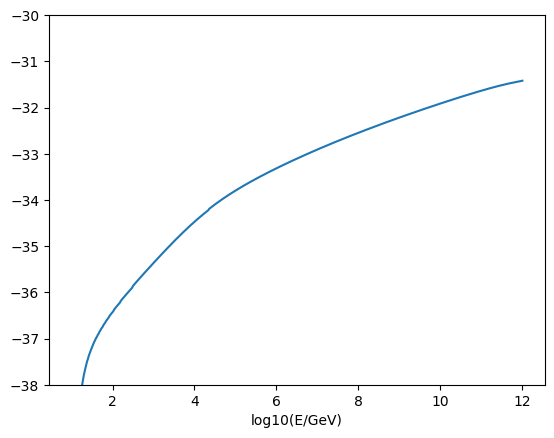

In [9]:
plt.plot(log10etbl-9, xsec_spline_energy(log10etbl-9))
plt.ylim(-38, -30)
plt.xlabel("log10(E/GeV)")

In [9]:
splines = {"transmission_prob": transm_splines, "xsec": xsec_splines, "xsec_min_e": 10. }# GeV}
pickle.dump(splines, open("/workspaces/NeutrinoTelescopes/assets/transm_inter_splines.pickle", "wb"))

## Effective Area

In [7]:
pos_acc_df = pd.read_pickle("../data/em_casc_pos_uncert_accept_fisher.pickle")
pos_acc_df = pos_acc_df.loc[(slice(None), "Full pessimistic cluster", slice(None), slice(None), 16)]

In [9]:
molar_mass_water = 18.01528 # g / mol
density = 1000 # kg / m^3
na = 6.02214076E23 # 1 / mol
n_nucleons = 18 * density / (molar_mass_water / 1000) * na # 1 / m^3


a_eff_cos_bins = np.linspace(-1, 1, 40)
a_eff_e_bins = np.linspace(3, 6, 41)
a_effs = []



In [11]:

aeff_hists = []
nsample = int(1E6)
for spacing, spacing_group in acc_df.groupby(level=2):

    det = Detector(make_hex_grid(3, spacing, 20, 50, dark_noise_rate, rng, efficiency=efficiency, truncate=1))
    cylinder_height=det._outer_cylinder[1] + 100
    cylinder_radius=det._outer_cylinder[0] + 50
    cylinder_volume=cylinder_height * cylinder_radius**2 * np.pi

    dirs = sample_direction(nsample, rng)
    poss = sample_cylinder_volume(cylinder_height, cylinder_radius, nsample, rng)
    logesmpl = np.random.uniform(3, 6, nsample)

    xs = 10**(xsec_spline_energy(logesmpl)) * 1E-4 # m^2
    interaction_coeff = xs * n_nucleons

    transmission_probs = transmission_prob_spline(dirs[:, 2], logesmpl, grid=False)

    chord_lengths = []
    proj_areas = []

    for p, d in zip(poss, dirs):
        isec_ps = track_isects_cyl(cylinder_radius, cylinder_height, p, d)
        proj_area = get_proj_area_for_zen(cylinder_height, cylinder_radius, d[2])
        
        chord_lengths.append(np.abs(np.diff(isec_ps)).item())
        proj_areas.append(proj_area)
    chord_lengths = np.asarray(chord_lengths)
    proj_areas = np.asarray(proj_areas)

    #taylor: 1 - exp(-x) ~ x
    int_prob = interaction_coeff * chord_lengths

    total_prob = int_prob * transmission_probs

    eff_areas_contribs = total_prob * proj_areas
    eff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

    eff_volume_contribs = np.ones_like(total_prob) * cylinder_volume
    eff_v_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_volume_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

    aeff_hists.append(
        {
            "hit_threshold": None,
            "module_threshold": None,
            "spacing": spacing,
            "aeff_hist": eff_hist.statistic,
            "veff_hist": eff_v_hist.statistic,
            "min_pos_resolution": None
        })


    for (mt, ht), mt_ht_group in spacing_group.groupby(level=[0, 1]):
        if len(mt_ht_group) > 1:
            raise RuntimeError()
        acc_prob = mt_ht_group["acceptance"].values[0](logesmpl)
        total_prob = int_prob * transmission_probs * acc_prob

        eff_areas_contribs = total_prob * proj_areas
        eff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

        eff_volume_contribs = acc_prob * cylinder_volume
        eff_v_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_volume_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))
        aeff_hists.append(
            {
                "hit_threshold": ht,
                "module_threshold": mt,
                "spacing": spacing,
                "aeff_hist": eff_hist.statistic,
                "veff_hist": eff_v_hist.statistic,
                "min_pos_resolution": None
            })

        if spacing in pos_acc_df.index.levels[1]:

            for min_pos_res, pra_grp in pos_acc_df.loc[(slice(None), spacing, slice(None))].groupby(level=0):
                spline = UnivariateSpline(np.log10(pra_grp.index.levels[1]), pra_grp.values, s=0, k=1)
                pos_acc = spline(logesmpl)

                eff_areas_contribs = total_prob * proj_areas * pos_acc
                eff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

                eff_volume_contribs = acc_prob * cylinder_volume * pos_acc
                eff_v_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_volume_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))

                aeff_hists.append(
                {
                    "hit_threshold": ht,
                    "module_threshold": mt,
                    "spacing": spacing,
                    "aeff_hist": eff_hist.statistic,
                    "veff_hist": eff_v_hist.statistic,
                    "min_pos_resolution": min_pos_res
                })




"""
for mt, ht, spacing_ix in product(mod_threshs, hit_threshs, range(len(spacings))):



    acc_prob = acc_dicts[spacing_ix][(mt, ht)](logesmpl)
    total_prob_cd = column_density * transmission_probs * acc_prob


    eff_areas_contribs = []
    for p, d, prob in zip(poss, dirs, total_prob_cd):
        isec_ps = track_isects_cyl(cylinder_radius, cylinder_height, p, d)
        proj_area = get_proj_area_for_zen(cylinder_height, cylinder_radius, d[2])
        # taylor
        int_prob = prob * isec_ps[1]
        eff_areas_contribs.append(proj_area * int_prob)
    aeff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))
"""
    

   







'\nfor mt, ht, spacing_ix in product(mod_threshs, hit_threshs, range(len(spacings))):\n\n\n\n    acc_prob = acc_dicts[spacing_ix][(mt, ht)](logesmpl)\n    total_prob_cd = column_density * transmission_probs * acc_prob\n\n\n    eff_areas_contribs = []\n    for p, d, prob in zip(poss, dirs, total_prob_cd):\n        isec_ps = track_isects_cyl(cylinder_radius, cylinder_height, p, d)\n        proj_area = get_proj_area_for_zen(cylinder_height, cylinder_radius, d[2])\n        # taylor\n        int_prob = prob * isec_ps[1]\n        eff_areas_contribs.append(proj_area * int_prob)\n    aeff_hist = scipy.stats.binned_statistic_2d(dirs[:, 2], logesmpl, eff_areas_contribs, bins=(a_eff_cos_bins, a_eff_e_bins))\n'

In [96]:


np.cos(np.degrees(95))

-0.28574274472927647

In [8]:
def sample_downgoing(nsample, rng):
    theta = np.arccos(rng.uniform(np.cos(np.degrees(95)), 1, size=nsample))
    phi = rng.uniform(0, 2*np.pi, size=nsample)

    return np.stack([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)], axis=1)


In [11]:
#det = Detector(make_hex_grid(3, spacing, 20, 50, dark_noise_rate, rng, efficiency=efficiency, truncate=1))
nsample = (int(1E6))
rng = np.random.RandomState(10)
cylinder_height=1000 + 100
cylinder_radius=500 + 50

dirs = sample_downgoing(nsample, rng)
poss = sample_cylinder_volume(cylinder_height, cylinder_radius, nsample, rng)
logesmpl = np.random.uniform(3, 6, nsample)

xs = 10**(xsec_spline_energy(logesmpl)) * 1E-4 # m^2
column_density = xs * n_nucleons

transmission_probs = transmission_prob_spline(dirs[:, 2], logesmpl, grid=False)

dist_before = []
proj_areas = []

for p, d in zip(poss, dirs):
    isec_ps = track_isects_cyl(cylinder_radius, cylinder_height, p, d)
    proj_area = get_proj_area_for_zen(cylinder_height, cylinder_radius, d[2])
    dist_before.append(np.abs(np.diff(isec_ps)).item())
    proj_areas.append(proj_area)



dist_before = np.asarray(dist_before)
proj_areas = np.asarray(proj_areas)


#taylor: 1 - exp(-x) ~ x
int_prob = column_density * dist_before 
total_prob = int_prob * transmission_probs

eff_areas_contribs = total_prob * proj_areas

eff_hist = scipy.stats.binned_statistic(logesmpl, eff_areas_contribs, bins= a_eff_e_bins)




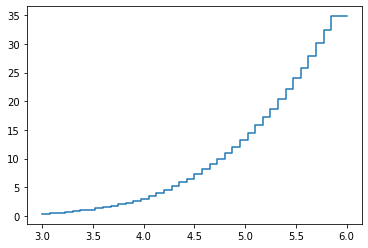

In [13]:
plt.step(a_eff_e_bins, np.append(eff_hist[0], eff_hist[0][-1]))

In [57]:
track_isects_cyl(cylinder_radius, cylinder_height, np.asarray([-550, 0, 0]), np.asarray([1, 0, 0]))

(0.0, 1100.0)

In [50]:
10**xsec_spline_energy(6)

4.837063141754472e-34

In [53]:
density / 1.67E-27

5.988023952095808e+29

In [51]:
1 / 1.67E-27 # kg

5.988023952095808e+26

In [14]:
aeff_df = pd.DataFrame(aeff_hists).set_index(["hit_threshold", "module_threshold", "min_pos_resolution", "spacing", ])
pickle.dump((a_eff_cos_bins, a_eff_e_bins, aeff_df), open("../data/aeff_cluster_nuecc.pickle", "wb"))
#a_eff_cos_bins, a_eff_e_bins, aeff_df = pickle.load(open("../data/aeff_cluster_nuecc.pickle", "rb"))

/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_623/1370687514.py:13: PerformanceWarning: ind

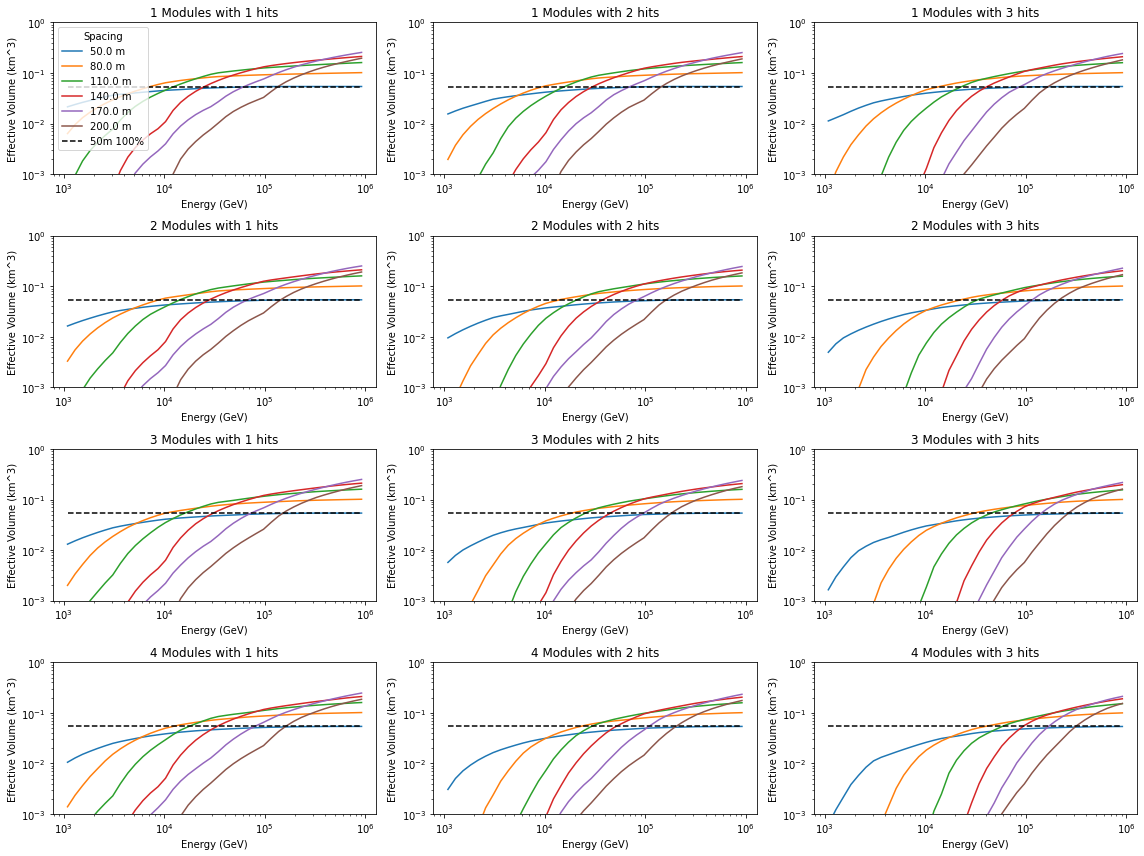

In [23]:
bc = 0.5*(a_eff_e_bins[1:] + a_eff_e_bins[:-1])

trigger_settings = [(1,1), (1, 2), (1, 3), (2, 1), (2,2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4,2), (4, 3)]

pos_res_thresh = 1

fig, axs = plt.subplots(4, 3, figsize=(4*4, 4*3))
aeff_df_ref = aeff_df.loc[(slice(None), slice(None), slice(None), 50)]


for (mt, ht), ax in zip(trigger_settings, axs.ravel()):

    for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
        ax.plot(10**bc, np.average(group["veff_hist"].values[0]/1E9, axis=0), label=f"{groupn} m")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylabel("Effective Volume (km^3)")
        ax.set_ylim(1E-3, 1)
        ax.set_title(f"{mt} Modules with {ht} hits")
    ax.plot(10**bc, np.average(aeff_df_ref["veff_hist"].values[0]/1E9, axis=0), ls="--", color="k", label="50m 100%")
        
axs[0][0].legend(title="Spacing")

plt.tight_layout()
plt.savefig("../figures/em_casc_veff_nc_edep_theta_avg_triggers_pos_res1.png", dpi=150)





/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_493/3173851121.py:11: PerformanceWarning: ind

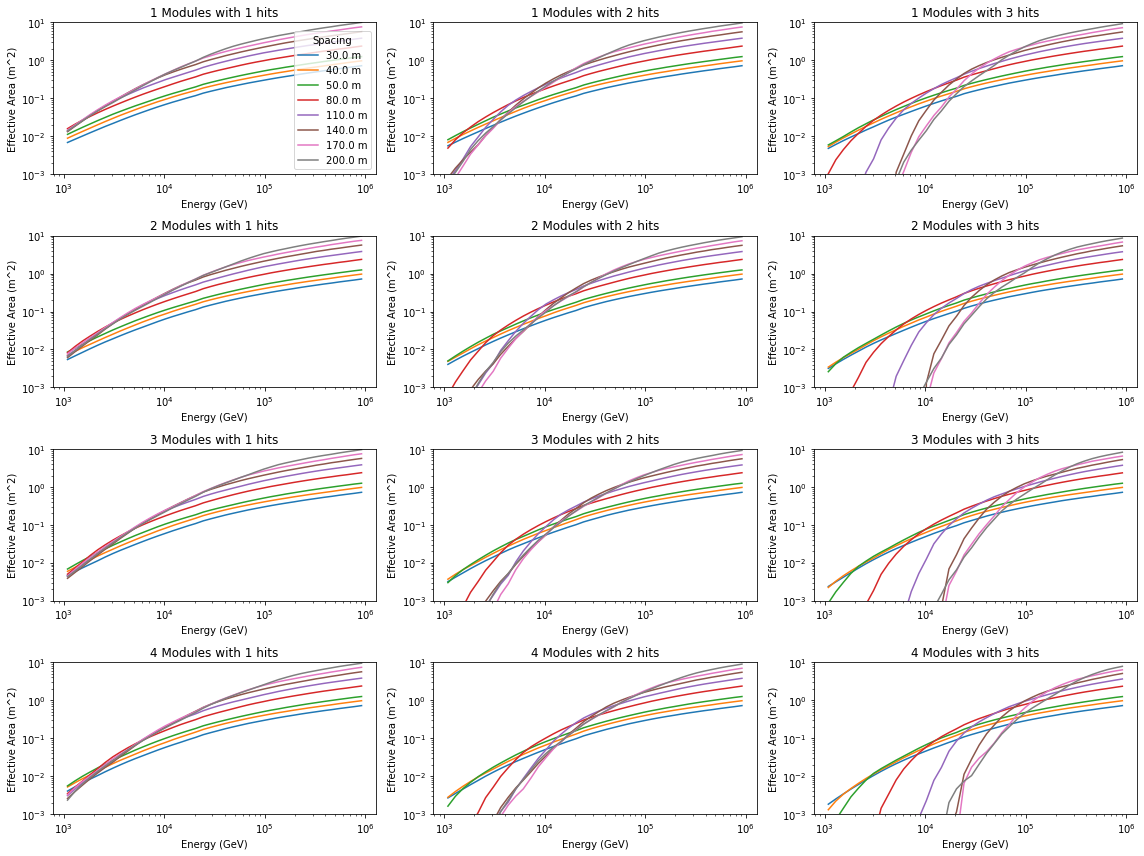

In [6]:
bc = 0.5*(a_eff_e_bins[1:] + a_eff_e_bins[:-1])

trigger_settings = [(1,1), (1, 2), (1, 3), (2, 1), (2,2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4,2), (4, 3)]

pos_res_thresh = None

fig, axs = plt.subplots(4, 3, figsize=(4*4, 4*3))

for (mt, ht), ax in zip(trigger_settings, axs.ravel()):

    for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
        ax.plot(10**bc, np.average(group["aeff_hist"].values[0], axis=0), label=f"{groupn} m")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylabel("Effective Area (m^2)")
        ax.set_ylim(1E-3, 10)
        ax.set_title(f"{mt} Modules with {ht} hits")
axs[0][0].legend(title="Spacing")

plt.tight_layout()
plt.savefig("../figures/em_casc_aeff_nc_edep_theta_avg_triggers.png", dpi=150)





/tmp/ipykernel_172178/1057378841.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_172178/1057378841.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_172178/1057378841.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
/tmp/ipykernel_172178/1057378841.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):


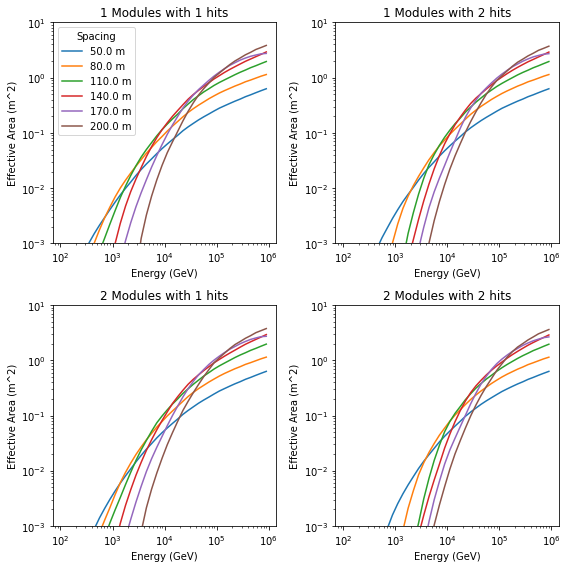

In [46]:
bc = 0.5*(a_eff_e_bins[1:] + a_eff_e_bins[:-1])

trigger_settings = [(1,1), (1, 2), (2, 1), (2,2)]

pos_res_thresh = 5

fig, axs = plt.subplots(2, 2, figsize=(4*2, 4*2))

for (mt, ht), ax in zip(trigger_settings, axs.ravel()):

    for groupn, group in aeff_df.loc[mt, ht, pos_res_thresh].groupby(level=[0]):
        ax.plot(10**bc, np.average(group["aeff_hist"].values[0], axis=0), label=f"{groupn} m")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylabel("Effective Area (m^2)")
        ax.set_ylim(1E-3, 10)
        ax.set_title(f"{mt} Modules with {ht} hits")
axs[0][0].legend(title="Spacing")

plt.tight_layout()
plt.savefig("../figures/em_casc_aeff_nc_edep_theta_avg_triggers.png", dpi=150)





In [30]:
aeff_df.index

MultiIndex([(1, 1, nan,  30.0),
            (2, 1, nan,  30.0),
            (3, 1, nan,  30.0),
            (4, 1, nan,  30.0),
            (5, 1, nan,  30.0),
            (1, 2, nan,  30.0),
            (2, 2, nan,  30.0),
            (3, 2, nan,  30.0),
            (4, 2, nan,  30.0),
            (5, 2, nan,  30.0),
            ...
            (3, 5, 2.0, 200.0),
            (3, 5, 5.0, 200.0),
            (4, 5, nan, 200.0),
            (4, 5, 1.0, 200.0),
            (4, 5, 2.0, 200.0),
            (4, 5, 5.0, 200.0),
            (5, 5, nan, 200.0),
            (5, 5, 1.0, 200.0),
            (5, 5, 2.0, 200.0),
            (5, 5, 5.0, 200.0)],
           names=['hit_threshold', 'module_threshold', 'min_pos_resolution', 'spacing'], length=650)

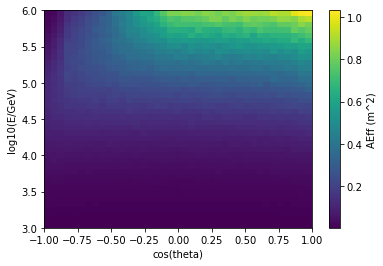

In [31]:
plt.figure()
plt.pcolormesh(a_eff_cos_bins, a_eff_e_bins, (aeff_df.loc[1, 1, None, 50].values[0]).T)
cbar = plt.colorbar()
cbar.set_label("AEff (m^2)")
plt.xlabel("cos(theta)")
plt.ylabel("log10(E/GeV)")
plt.savefig("../figures/aeff_cluster_nue_cc")

#np.savez("../data/aeff_cluster_100m_nue_cc cos_theta_edges=a_eff_cos_bins, log10_e_edges=a_eff_e_bins, aeff=aeff_hists[1])


In [53]:
efficiency * 0.21**2 / 100**2 * np.exp(-100/20) * 0.25

9.475237967463937e-10

In [54]:
efficiency

0.12755102040816327

In [51]:


efficiency

0.12755102040816327

In [52]:

np.exp(-100/20)

0.006737946999085467